
# Using ANN model for longawave estimation of cloud fraction 


## Step 1 - Import and init

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import time
import keras_tuner as kt 

from tensorflow import keras
from keras.callbacks import EarlyStopping
from numpy import loadtxt
from keras.models import load_model
from pathlib import Path
from keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters 

sys.path.append('..')
path = '/home/monitor/IGE_DOC/GIT_REPO/LongwaveEstimationOfCloudFraction-With-XGBoost-And-ANNmodel/Data/'


## Step 2 - Retrieve data

In [15]:
data = pd.read_csv(path + 'DataForML_5min.csv', header=0)
del data['timestamp']
data

,GSW,SWDif,SWDir,LWdn,T,H,P,CF
0,1101.2,257.0,929.6,369.2,25.08,51.08,1010.0,0.4502
1,1004.8,385.8,683.2,378.8,24.62,53.58,1010.0,0.5632
2,942.0,479.8,509.2,388.8,24.52,55.04,1010.0,0.6224
3,432.2,410.8,21.4,388.8,23.76,56.80,1010.0,0.5408
4,823.4,370.2,490.4,374.4,24.02,55.60,1010.0,0.3544
...,...,...,...,...,...,...,...,...
64923,357.2,355.6,2.6,425.8,27.34,65.78,1003.0,0.7756
64924,352.8,352.0,0.6,428.6,27.38,65.62,1003.0,0.8020
64925,360.2,358.4,1.6,430.6,27.36,65.70,1003.0,0.8096
64926,415.2,399.6,19.6,430.8,27.40,65.86,1003.0,0.7588


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 90% of the data for training and 10% for validation.  
The dataset is **shuffled** and shared between **learning** and **testing**.  
x will be input data and y the expected output

In [6]:
data_pred       = data[-10000:]

y_real          = data_pred['CF']
x_pred          = data_pred.drop('CF',  axis=1)

data_pred = data_pred.reset_index()

data_pred = data_pred.drop('index', axis=1)
data_pred

,GSW,SWDif,SWDir,LWdn,T,H,P,CF
0,356.4,54.4,785.4,373.8,27.44,48.26,1005.0,0.0756
1,376.4,55.8,797.6,373.8,27.48,48.32,1005.0,0.1180
2,396.2,57.4,808.4,374.2,27.54,48.04,1005.0,0.1242
3,416.2,58.8,818.2,374.2,27.76,47.48,1005.0,0.1292
4,435.2,60.4,825.4,374.4,27.42,48.14,1005.0,0.1342
...,...,...,...,...,...,...,...,...
9995,357.2,355.6,2.6,425.8,27.34,65.78,1003.0,0.7756
9996,352.8,352.0,0.6,428.6,27.38,65.62,1003.0,0.8020
9997,360.2,358.4,1.6,430.6,27.36,65.70,1003.0,0.8096
9998,415.2,399.6,19.6,430.8,27.40,65.86,1003.0,0.7588


In [8]:
# ---- Shuffle and Split => train, test
#
data       = data.drop(data_pred.index)
data       = data.sample(frac=1., axis=0)
data_train = data.sample(frac=0.95, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('CF',  axis=1)
y_train = data_train['CF']
x_test  = data_test.drop('CF',   axis=1)
y_test  = data_test['CF']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
print('x_pred  : ',x_pred.shape,  'y_real  : ',y_real.shape)

Original data shape was :  (54928, 8)
x_train :  (52182, 7) y_train :  (52182,)
x_test  :  (2746, 7) y_test  :  (2746,)
x_pred  :  (10000, 7) y_real  :  (10000,)


In [9]:
x_train.shape, x_test.shape

((52182, 7), (2746, 7))

### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [10]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,GSW,SWDif,SWDir,LWdn,T,H,P
count,52182.00,52182.00,52182.00,52182.00,52182.00,52182.00,52182.00
mean,468.84,190.80,400.23,398.56,26.50,61.28,1003.83
std,327.69,143.66,386.34,29.17,2.52,9.64,4.07
min,10.00,9.00,-1.00,308.60,16.90,27.16,929.80
25%,177.00,80.40,0.80,378.00,24.70,54.68,1001.00
50%,408.60,139.20,309.10,401.80,26.68,60.58,1004.00
75%,733.60,274.60,815.60,422.40,28.48,66.82,1007.00
max,1485.00,774.20,1028.60,461.40,34.22,93.82,1014.00


,GSW,SWDif,SWDir,LWdn,T,H,P
count,52182.00,52182.00,52182.00,52182.00,52182.00,52182.00,52182.00
mean,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.40,-1.27,-1.04,-3.08,-3.80,-3.54,-18.18
25%,-0.89,-0.77,-1.03,-0.70,-0.71,-0.68,-0.69
50%,-0.18,-0.36,-0.24,0.11,0.07,-0.07,0.04
75%,0.81,0.58,1.08,0.82,0.78,0.57,0.78
max,3.10,4.06,1.63,2.15,3.06,3.37,2.50


,GSW,SWDif,SWDir,LWdn,T,H,P
45803,0.09,1.82,-0.93,0.82,-0.09,0.02,0.53
44583,1.45,-0.64,1.45,-1.93,-0.09,-2.90,1.27
54196,-1.26,-0.93,-1.04,0.08,-0.13,1.28,-0.25
55312,-0.58,-0.96,0.84,-0.94,-0.45,0.65,0.04
22952,-1.27,-0.97,-1.04,0.67,-0.03,0.92,-1.43


In [11]:
display(x_pred.describe().style.format("{0:.2f}").set_caption("Before normalization :"))
# for pred 
x_pred = (x_pred - mean) / std

display(x_pred.describe().style.format("{0:.2f}").set_caption("After normalization :"))
display(x_pred.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_pred,  y_real  = np.array(x_pred),  np.array(y_real)

,GSW,SWDif,SWDir,LWdn,T,H,P
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,521.28,191.02,437.97,410.06,28.20,63.17,1001.41
std,360.78,155.21,407.09,22.78,1.72,9.93,1.94
min,10.00,10.20,-1.00,346.20,22.00,27.16,995.00
25%,190.00,76.60,1.00,392.80,27.08,55.96,1000.00
50%,469.30,122.40,400.50,409.80,28.44,61.84,1002.00
75%,843.85,280.00,879.00,430.20,29.48,68.94,1003.00
max,1485.00,774.20,1028.60,457.60,34.22,93.82,1005.00


,GSW,SWDif,SWDir,LWdn,T,H,P
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,0.16,0.00,0.10,0.39,0.67,0.20,-0.59
std,1.10,1.08,1.05,0.78,0.68,1.03,0.48
min,-1.40,-1.26,-1.04,-1.79,-1.78,-3.54,-2.17
25%,-0.85,-0.79,-1.03,-0.20,0.23,-0.55,-0.94
50%,0.00,-0.48,0.00,0.39,0.77,0.06,-0.45
75%,1.14,0.62,1.24,1.08,1.18,0.79,-0.20
max,3.10,4.06,1.63,2.02,3.06,3.37,0.29


,GSW,SWDif,SWDir,LWdn,T,H,P
54928,-0.34,-0.95,1.00,-0.85,0.37,-1.35,0.29
54929,-0.28,-0.94,1.03,-0.85,0.39,-1.34,0.29
54930,-0.22,-0.93,1.06,-0.84,0.41,-1.37,0.29
54931,-0.16,-0.92,1.08,-0.84,0.50,-1.43,0.29
54932,-0.10,-0.91,1.10,-0.83,0.37,-1.36,0.29


## Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)
 
 The range of layers and neuron have been chosen according to the data and the number of features.

In [13]:
def build_model(hp):
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(7, name="InputLayer"))
    
    model.add(keras.layers.Dense(hp.Choice('units', [8, 10, 12]), activation='relu', name='Dense_n1'))
    
    model.add(keras.layers.Dense(hp.Choice('units', [8, 10, 12]), activation='relu', name='Dense_n2'))
    
    model.add(keras.layers.Dense(hp.Choice('units', [8, 10, 12]), activation='relu', name='Dense_n3'))
    
    model.add(keras.layers.Dense(1, name='Output'))
    
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate=learning_rate),
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'])
    
    return model

Here we use keras tuner to tune the model. There are many package that we can use for optimizing or tuning the hyperparameters. We chose keras tuner beacause it's easy to use. 

Model to optimize :

In [14]:
hp = HyperParameters()

shape = 7 

build_model(kt.HyperParameters())

RandomSearch method  for Tuning hyperparameters  

In [16]:
tuner = kt.RandomSearch(hypermodel=build_model, objective="val_loss",
                        
                        max_trials=3,executions_per_trial=2,overwrite=True,
                        
                        directory="D:/TUTO/data_science/formation_fedel/fidle-master/BHPD/Optimization_results", project_name="Optim_RandomForest",)

Summary

In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 10, 12], 'ordered': True}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}




Runing keras tuner and search the best hyperparameters



In [18]:

tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))  # , callbacks=[stop_early]


Trial 3 Complete [00h 03m 19s]
val_loss: 0.00873398594558239

Best val_loss So Far: 0.00873398594558239
Total elapsed time: 00h 11m 22s
INFO:tensorflow:Oracle triggered exit


Here we take the best model 

In [19]:
# Get the top 2 models.
# models = tuner.get_best_models(num_models=1)

best_model_1 =  tuner.get_best_models()[0]

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_model_1 , best_hps

(<keras.engine.sequential.Sequential at 0x2bdb3d64070>,
 <keras_tuner.engine.hyperparameters.HyperParameters at 0x2bdb5c71b50>)

## Step 5 - Train the model
### 5.1 - Get it

In [22]:
best_model = tuner.hypermodel.build(best_hps)
tuner.results_summary()

Results summary
Results in D:/TUTO/data_science/formation_fedel/fidle-master/BHPD/Optimization_results\Optim_RandomForest
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 10
lr: 0.004357747864910277
Score: 0.00873398594558239
Trial summary
Hyperparameters:
units: 8
lr: 0.0058540376975635125
Score: 0.009038576390594244
Trial summary
Hyperparameters:
units: 10
lr: 0.00763827492703537
Score: 0.009123616386204958


### 5.2 - Train it

We need to retrain the best model 

In [29]:
es       =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

checkpoint_cb = keras.callbacks.ModelCheckpoint("check_point_my_keras_model.h5",save_best_only=True)

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(x_train,
                    y_train,
                    epochs          = 50,  #60 init 
                    batch_size      = 10,  #10
                    verbose         = fit_verbosity,
                    callbacks       =[es,checkpoint_cb],
                    validation_data = (x_test, y_test))

Epoch 1/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0136 - mae: 0.0791 - mse: 0.0136 - val_loss: 0.0112 - val_mae: 0.0739 - val_mse: 0.0112
Epoch 2/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0108 - mae: 0.0716 - mse: 0.0108 - val_loss: 0.0115 - val_mae: 0.0724 - val_mse: 0.0115
Epoch 3/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0105 - mae: 0.0706 - mse: 0.0105 - val_loss: 0.0113 - val_mae: 0.0738 - val_mse: 0.0113
Epoch 4/50
5219/5219 [==============================] - 6s 1ms/step - loss: 0.0103 - mae: 0.0694 - mse: 0.0103 - val_loss: 0.0103 - val_mae: 0.0699 - val_mse: 0.0103
Epoch 5/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0101 - mae: 0.0683 - mse: 0.0101 - val_loss: 0.0100 - val_mae: 0.0678 - val_mse: 0.0100
Epoch 6/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0100 - mae: 0.0680 - mse: 0.0100 - val_loss: 0.0099 - val_mae: 0.0661 - val_mse: 0.0099
Epoc

#### Recovery of the model in the event of a training stoppage 

In [ ]:
model = keras.models.load_model("check_point_my_keras_model.h5") 

In [18]:
keras.utils.plot_model(best_model)

#### Best epoch for training 

In [16]:
val_loss_per_epoch = history.history['val_loss']

best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

We retrain with the best epoch 

In [33]:
best_model_epoch_ = tuner.hypermodel.build(best_hps)

history_2 = best_model_epoch_.fit(x_train,
                    y_train,
                    epochs          = 50,  #60 init 
                    batch_size      = 10,  #10
                    verbose         = fit_verbosity,
                    callbacks       =[es],
                    validation_data = (x_test, y_test))

Epoch 1/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0130 - mae: 0.0778 - mse: 0.0130 - val_loss: 0.0111 - val_mae: 0.0728 - val_mse: 0.0111
Epoch 2/50
5219/5219 [==============================] - 6s 1ms/step - loss: 0.0108 - mae: 0.0712 - mse: 0.0108 - val_loss: 0.0108 - val_mae: 0.0706 - val_mse: 0.0108
Epoch 3/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0105 - mae: 0.0702 - mse: 0.0105 - val_loss: 0.0117 - val_mae: 0.0779 - val_mse: 0.0117
Epoch 4/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0103 - mae: 0.0694 - mse: 0.0103 - val_loss: 0.0098 - val_mae: 0.0683 - val_mse: 0.0098
Epoch 5/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0102 - mae: 0.0685 - mse: 0.0102 - val_loss: 0.0100 - val_mae: 0.0669 - val_mse: 0.0100
Epoch 6/50
5219/5219 [==============================] - 7s 1ms/step - loss: 0.0100 - mae: 0.0678 - mse: 0.0100 - val_loss: 0.0102 - val_mae: 0.0657 - val_mse: 0.0102
Epoc

In [34]:
eval_result = best_model.evaluate(x_test, y_test)
print("[test loss, test score]:", eval_result)

86/86 [==============================] - 0s 2ms/step - loss: 0.0092 - mae: 0.0663 - mse: 0.0092
[test loss, test score]: [0.00915032159537077, 0.06628234684467316, 0.00915032159537077]


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  

In [35]:
score = best_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

for i in range(3):
    print("%s: %.2f%%" % (best_model.metrics_names[i], score[i]*100))

x_test / loss      : 0.0092
x_test / mae       : 0.0663
x_test / mse       : 0.0092
loss: 0.92%
mae: 6.63%
mse: 0.92%


In [ ]:
Name_to_save = "50_3L_epoch_Best_model_ANN"
np.mean(score[0]*100)

### Save history in a csv file

In [11]:
df=pd.DataFrame(data=history_2.history)

filepath = Path('D:\TUTO\data science\formation_fedel\fidle-datasets\model.csv')  

df.to_csv(Name_to_save+'.csv')  

### Save model 

In [39]:
NAME = Name_to_save+"_{}".format(int(time.time())) 

# save model and architecture to single file
best_model.save(NAME+".h5")

print("Saved model to disk")

Saved model to disk


### Load model 

In [18]:
# load and evaluate a saved model

# load model
model = load_model(NAME+".h5")
# model = load_model("50_3L_epoch_Best_model_ANN_1645999529.h5")

# summarize model.
model.summary()

# evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
for i in range(3):
    print("%s: %.2f%%" % (model.metrics_names[i], score[i]*100))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 10)                80        
                                                                 
 Dense_n2 (Dense)            (None, 10)                110       
                                                                 
 Dense_n3 (Dense)            (None, 10)                110       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
loss: 0.86%
mae: 6.58%
mse: 0.86%


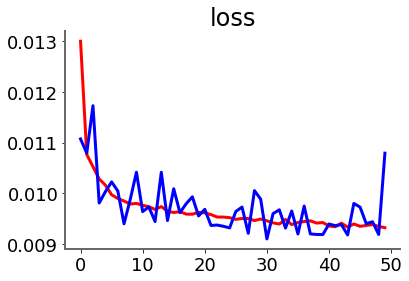

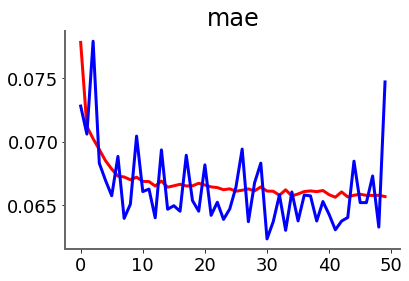

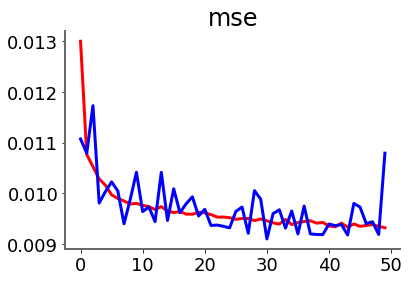

In [19]:
# figure, axis = plt.subplots(1, 3, figsize=(25,8))
for i in range(3):
    
    plt.plot(range(50), df[cols[i]], 'r')
    
    plt.plot(range(50), df[cols[i+3]], 'b')
    
    plt.title(cols[i])
    
    plt.show()


In [17]:
print("min( val_mae ) : {:.4f}".format( min(history_2.history["val_mae"]) ) )

## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

### Plot outcome 

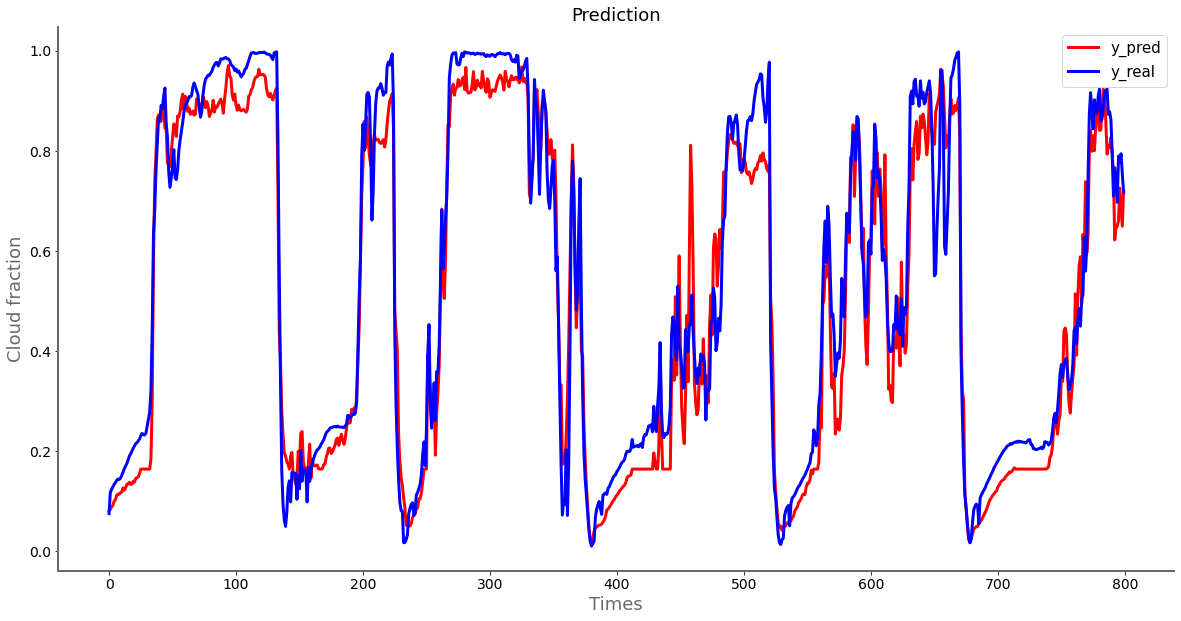

In [30]:
def plot_pred(start,end, y_pred, y):  
    
    # Setup plot (2 rows, 1 column)
    fig, comb = plt.subplots(nrows=1,ncols=1, sharex=True, figsize=(20, 10))
    
    # PLOT sup
    comb.plot(range(len(y_pred[start:end])),y_pred[start:end], color='r', label = "y_pred") 
    
    comb.plot(range(len(y[start:end])),y[start:end], color='b', label = "y_real")
    
    comb.set_title("Prediction", fontsize=18)
    
    comb.legend(prop={'size':15})
    
    comb.set_ylabel('Cloud fraction', fontsize=18)
    
    comb.set_xlabel('Times', fontsize=18)
    
    comb.tick_params(labelsize=14)
    
    return 

data_comp_resutl = pd.DataFrame({'y_pred': y_pred_cln, 'y_real': y_real[:].tolist()})

start = 0

for i in range(1):
    
    end = start + 800
    
    plot_pred(start,end,data_comp_resutl['y_pred'], data_comp_resutl['y_real'])
    
    start = start + end
    

### Score 

* r2_score

In [48]:
round(r2_score(y_real[:], predictions[0][:]),4)*100

91.78